## This is a notebook that verify the communication of the pointing kernel with the hexapods (including the rotator and Mount)
It is part of a series of notebook that tests the communication between the pointing kernel and different components:
- the mount
- the rotator
- M1M3
- M2
- Cam hexapod
- M2 hexapod
We will leave ComCam out of this notebook

The goals of the exercice are 
- Check heartbeat from all components.
- Make sure we can put all components in ENABLE state and back to STANDBY.
- Check the EFD to ensure that the correct events/commands/telemetry is published

This will ensure that we are ready to check the slew when needed


Library loading

In [1]:
#from lsst.ts.observatory.maintel import MTCS
from lsst.ts import salobj
from lsst.ts.idl.enums import ATPtg

import asyncio

import numpy as np
from matplotlib import pyplot as plt
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
from astropy.utils import iers
iers.conf.auto_download = True

from datetime import datetime



Bad key "text.kerning_factor" on line 4 in
/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Set up -> things that would go into the tcs script

In [ ]:
now = datetime.now()

In [46]:
start_time = datetime.now()
script = salobj.Controller("Script", index=1)
#add a sleep right now (january 2021)
await asyncio.sleep(10.)

mtptg = salobj.Remote(script.domain, "MTPtg")
rot = salobj.Remote(script.domain, "MTRotator")
print(f'time to start is {datetime.now() - start_time} [s]')

RuntimeError: Cannot find IDL file /opt/lsst/src/ts_idl/idl/sal_revCoded_NewMTMount.idl for name='NewMTMount'

guidingAndOffsets DDS read queue is filling: 10 of 100 elements
currentTargetStatus DDS read queue is filling: 10 of 100 elements


In [ ]:
mtm = salobj.Remote(script.domain, "NewMTMount")

In [3]:
camHex = salobj.Remote(script.domain, "MTHexapod", index = '1')
m2Hex = salobj.Remote(script.domain, "MTHexapod", index = '2')
#print(f'time to start is {datetime.now() - start_time} [s]')

tracking DDS read queue is filling: 80 of 100 elements
target DDS read queue is full (100 elements); data may be lost
electrical DDS read queue is filling: 12 of 100 elements
application DDS read queue is filling: 12 of 100 elements
actuators DDS read queue is filling: 13 of 100 elements


In [5]:
await asyncio.gather(mtptg.start_task,
                     script.start_task,
                     rot.start_task,
                     camHex.start_task,
                     m2Hex.start_task)

[None, None, None, None, None]

In [ ]:
await mtptg.evt_heartbeat.next(flush=True, timeout=5)

In [ ]:
await rot.evt_heartbeat.next(flush=True, timeout=5)
await camHex.evt_heartbeat.next(flush=True, timeout=5)
await m2Hex.evt_heartbeat.next(flush=True, timeout=5)

In [ ]:
summary_state =  await mtptg.evt_summaryState.aget(timeout=5)
print(salobj.State(summary_state.summaryState))

#await mtptg.cmd_start.start(timeout=5)
I don't need it? depends… if the mtptg is enable, then you don’t need it
you can replace that one with
await salobj.set_summary_state(mtptg, salobj.State.ENABLED)
which will make sure the CSC is in enabled state at the end…

Check the state of the system

In [13]:
await salobj.set_summary_state(mtptg, salobj.State.ENABLED)

[<State.FAULT: 3>, <State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [14]:
await salobj.set_summary_state(rot, salobj.State.ENABLED)

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [ ]:
await salobj.set_summary_state(m2Hex, salobj.State.ENABLED)

In [ ]:
await salobj.set_summary_state(camHex, salobj.State.ENABLED)

In [ ]:
await salobj.set_summary_state(m1m3, salobj.State.STANDBY, timeout=5)

In [ ]:
await salobj.set_summary_state(m1m3, salobj.State.ENABLED, settingsToApply="Default", timeout=5)

In [ ]:
await m1m3.cmd_setLogLevel.set_start(level=50)

In [ ]:
#Check which hexapod we are controlling
whichHex1 = await camHex.evt_configuration.aget(timeout=10.)
print("Hexapod camHex", whichHex1.MTHexapodID)
print(camHex.salinfo.index)

whichHex2 = await m2Hex.evt_configuration.aget(timeout=10.)
print("Hexapod m2Hex", whichHex2.MTHexapodID)
print(m2Hex.salinfo.index)

In [ ]:
print(whichHex1)

In [ ]:
camHexPosition0 = await camHex.tel_actuators.aget(timeout=10.)
print(camHexPosition0)

In [ ]:
#print("camera Hexapod positions", camHexPosition.MTHexapodID,  camHexPosition.calibrated0,  camHexPosition.calibrated1,  camHexPosition.calibrated2,  camHexPosition.calibrated3,  camHexPosition.calibrated4,  camHexPosition.calibrated5)
print("camera Hexapod positions", camHexPosition0.MTHexapodID,  camHexPosition0.calibrated)

In [ ]:
m2HexPosition0 = await m2Hex.tel_actuators.aget(timeout=10.)
print("M2 Hexapod positions", m2HexPosition0.MTHexapodID,  m2HexPosition0.calibrated)

Enter the location for the telescope for the pointing

In [15]:
location = EarthLocation.from_geodetic(lon=-70.747698*u.deg,
                                       lat=-30.244728*u.deg,
                                       height=2663.0*u.m)

In [ ]:
#Get the elevation and rotator angle at the beginning of a run.


In [ ]:
mtptgDemand0 = await mtptg.tel_currentTargetStatus.aget(timeout=10.)
print("Current target status")
print("Az", mtptgDemand0.demandAz, "El", mtptgDemand0.demandEl, "Rot", mtptgDemand0.demandRot )

In [ ]:
# enable the hexapods LUT compensation
await m2Hex.cmd_setCompensationMode.set_start(enable=1, timeout=10)
await camHex.cmd_setCompensationMode.set_start(enable=1, timeout=10)

## Start of a first slew. Elevation of 80

In [16]:
now = datetime.now()
print("Start to point the telescope", now)

alt = 70. * u.deg
az = 25. * u.deg
rot_tel = Angle(0, unit= u.deg) 

target_name="TMA motion test"
#getting time for the pointing to ensure that we're using the time that the mount seems it is
time_data = await mtptg.tel_timeAndDate.next(flush=True, timeout=2)
#Convert the astropy class
curr_time_mtptg = Time(time_data.mjd, format="mjd", scale="tai")
#Check that we're getting the right time
time_err = curr_time_mtptg - Time.now()
print(f"Time error={time_err.sec:0.2f} sec")
print(curr_time_mtptg.tai.value)

#create the object with the alt az coordinate + time to be able to convert them in RA and Dec
cmd_elaz = AltAz(alt=alt, az=az, 
                obstime=curr_time_mtptg.tai, 
                location=location)
cmd_radec = cmd_elaz.transform_to(ICRS)

# Calculating the other parameters      
rot_pa = rot_tel
print(rot_pa)  


Start to point the telescope 2021-02-05 22:20:18.701361
Time error=27.00 sec
59250.9315136765
0d00m00s


In [ ]:
mtptgDemand = await mtptg.tel_currentTargetStatus.aget(timeout=10.)
print("Current target status")
print("Az", mtptgDemand.demandAz, "El", mtptgDemand.demandEl, "Rot", mtptgDemand.demandRot )

In [17]:
#The pointing component is commanding the mount directly
ack = await mtptg.cmd_raDecTarget.set_start(
    targetName=target_name,
    frame=ATPtg.CoordFrame.ICRS,
    epoch=2000,  # should be ignored: no parallax or proper motion
    equinox=2000,  # should be ignored for ICRS
    ra=cmd_radec.ra.hour,
    declination=cmd_radec.dec.deg,
    parallax=0,
    pmRA=0,
    pmDec=0,
    rv=0,
    dRA=0,
    dDec=0,
    rotPA=rot_pa.deg-180,
    rotFrame=ATPtg.RotFrame.FIXED,
    rotMode=ATPtg.RotMode.FIELD,
    timeout=10
)

print("Waiting 30s")
await asyncio.sleep(30.)
print("System Ready")

Waiting 30s
System Ready


## Check telemetry, only if no

In [ ]:
print(camHex.salinfo.command_names)

In [26]:
print(camHex.salinfo.event_names)

('actuatorInPosition', 'appliedSettingsMatchStart', 'authList', 'commandableByDDS', 'compensatedPosition', 'compensationMode', 'compensationOffset', 'configuration', 'connected', 'controllerState', 'errorCode', 'heartbeat', 'inPosition', 'interlock', 'logLevel', 'logMessage', 'settingVersions', 'settingsApplied', 'simulationMode', 'softwareVersions', 'summaryState', 'uncompensatedPosition')


In [ ]:
mtptgDemand = await mtptg.tel_currentTargetStatus.aget(timeout=10.)
print("Current target status")
print("Az", mtptgDemand.demandAz, "El", mtptgDemand.demandEl, "Rot", mtptgDemand.demandRot )
ElMat = np.array(mtptgDemand.demandEl)

rotAngle = await rot.tel_rotation.aget()
print(rotAngle.actualPosition)

#print("camera Hexapod positions", camHexPosition.MTHexapodID,  camHexPosition.calibrated0,  camHexPosition.calibrated1,  camHexPosition.calibrated2,  camHexPosition.calibrated3,  camHexPosition.calibrated4,  camHexPosition.calibrated5)
camHexPosition = await camHex.tel_actuators.aget(timeout=10.)
print("camera Hexapod positions", camHexPosition.MTHexapodID,  camHexPosition.calibrated)
camHexPosMat = np.array(camHexPosition.calibrated)

m2HexPosition = await m2Hex.tel_actuators.aget(timeout=10.)
print("M2 Hexapod positions", m2HexPosition.MTHexapodID,  m2HexPosition.calibrated)
m2HexPosMat = np.array(m2HexPosition.calibrated)

#Comparison between the actuator position before and after the move
#m2DiffHexpos = list(set(m2HexPosition.calibrated) - set(m2HexPosition0.calibrated))
#print("M2 Hex motion", m2DiffHexpos)
#camDiffHexpos = list(set(camHexPosition.calibrated) - set(camHexPosition0.calibrated))
#print("Cam Hex motion", camDiffHexpos)

# Start to loop a few Elevations

In [21]:
ElInputMat = np.arange(80,40,-10)
print(ElInputMat)

[80 70 60 50 40 30 20]


In [22]:
ElMat = []
camHexPosMat = [] 
m2HexPosMat = [] 
camHexPosDemMat = [] 
m2HexPosDemMat = [] 

for El in ElInputMat: 
    now = datetime.now()
    print("Start to point the telescope", now) 
    print("Elevation is", El)

    alt = El * u.deg
    az = 25. * u.deg
    rot_tel = Angle(0, unit= u.deg) 

    target_name="TMA motion test"
    #getting time for the pointing to ensure that we're using the time that the mount seems it is
    time_data = await mtptg.tel_timeAndDate.next(flush=True, timeout=2)
    #Convert the astropy class
    curr_time_mtptg = Time(time_data.mjd, format="mjd", scale="tai")
    #Check that we're getting the right time
    time_err = curr_time_mtptg - Time.now()
    print(f"Time error={time_err.sec:0.2f} sec")
    print(curr_time_mtptg.tai.value)

    #create the object with the alt az coordinate + time to be able to convert them in RA and Dec
    cmd_elaz = AltAz(alt=alt, az=az, 
                obstime=curr_time_mtptg.tai, 
                location=location)
    cmd_radec = cmd_elaz.transform_to(ICRS)

    # Calculating the other parameters      
    rot_pa = rot_tel
    print(rot_pa)
    
    #The pointing component is commanding the mount directly
    ack = await mtptg.cmd_raDecTarget.set_start(
        targetName=target_name,
        frame=ATPtg.CoordFrame.ICRS,
        epoch=2000,  # should be ignored: no parallax or proper motion
        equinox=2000,  # should be ignored for ICRS
        ra=cmd_radec.ra.hour,
        declination=cmd_radec.dec.deg,
        parallax=0,
        pmRA=0,
        pmDec=0,
        rv=0,
        dRA=0,
        dDec=0,
        rotPA=rot_pa.deg-180,
        rotFrame=ATPtg.RotFrame.FIXED,
        rotMode=ATPtg.RotMode.FIELD,
        timeout=10
    )

    print("Waiting 30s")
    await asyncio.sleep(30.)
    print("System Ready")
    
    
    ## Check telemetry

    mtptgDemand = await mtptg.tel_currentTargetStatus.aget(timeout=10.)
    print("Current target status")
    print("Az", mtptgDemand.demandAz, "El", mtptgDemand.demandEl, "Rot", mtptgDemand.demandRot )
    ElMat = np.append(ElMat,np.array(mtptgDemand.demandEl))

    #Evolution of the actuator position as a function of elevation the move
    camHexPosition = await camHex.tel_actuators.aget(timeout=10.)
    m2HexPosition = await m2Hex.tel_actuators.aget(timeout=10.)
    
    m2HexPosMat = np.append(m2HexPosMat, np.array(m2HexPosition.calibrated))
    camHexPosMat = np.append(camHexPosMat, np.array(camHexPosition.calibrated))

   #Evolution of the demanded actuator position as a function of elevation the move
    camHexPosition = await camHex.tel_actuators.aget(timeout=10.)
    m2HexPosition = await m2Hex.tel_actuators.aget(timeout=10.)
    
    m2HexPosMat = np.append(m2HexPosMat, np.array(m2HexPosition.calibrated))
    camHexPosMat = np.append(camHexPosMat, np.array(camHexPosition.calibrated))
    
    
    compensationOffset
    
print("End of loop")    

Start to point the telescope 2021-02-05 22:23:43.849834
Elevation is 80
Time error=27.00 sec
59250.93388928543
0d00m00s
Waiting 30s
System Ready
Current target status
Az 24.385540253830357 El 80.04689232339828 Rot -4.1382008930668235e-11
Start to point the telescope 2021-02-05 22:24:14.062621
Elevation is 70
Time error=27.00 sec
59250.934236885354
0d00m00s
Waiting 30s
System Ready
Current target status
Az 24.671204363929544 El 70.04935617446937 Rot 1.5722117901410456e-10
Start to point the telescope 2021-02-05 22:24:44.103422
Elevation is 60
Time error=26.99 sec
59250.93458453569
0d00m00s
Waiting 30s
System Ready
Current target status
Az 24.76982798281744 El 60.05203154736684 Rot 6.284776050571909e-11
Start to point the telescope 2021-02-05 22:25:14.145345
Elevation is 50
Time error=27.00 sec
59250.93493451153
0d00m00s
Waiting 30s
System Ready
Current target status
Az 24.822239931417176 El 50.05525084832555 Rot 2.1388594121905857e-10
Start to point the telescope 2021-02-05 22:25:44.375

## Plot of the evolution as a function of elevation

In [23]:
m2HexPosMat = np.reshape(m2HexPosMat,(-1,6))
print(m2HexPosMat)
print(ElMat)
plt.plot(ElMat, m2HexPosMat)
plt.show()

[[ 0.0166996   0.04421101  0.03338751 -0.01712617  0.00518884 -0.0102292 ]
 [ 0.04127951 -0.02720807  0.02294873 -0.04618353  0.04055954 -0.01016538]
 [ 0.04310654  0.04602008  0.01066748  0.04760403 -0.03310702  0.00506725]
 [-0.04929592 -0.00230314 -0.0453621   0.04559318  0.03166249  0.03545096]
 [ 0.01383064  0.02642035 -0.04240757  0.04721412 -0.03049139  0.02736028]
 [ 0.03595117 -0.0083958   0.04578388  0.01032187 -0.01042706  0.01353829]
 [ 0.00739975  0.02020089  0.02469375 -0.03694363  0.01325218  0.00221152]]
[80.04689232 70.04935617 60.05203155 50.05525085 40.05954285 30.06599037
 20.07807676]


[[ 0.00109151 -0.03115183 -0.00737149 -0.02901956 -0.02892928 -0.01132065]
 [-0.02469072  0.0132445  -0.03269304  0.03922763  0.03230629 -0.02323356]
 [ 0.02498998 -0.00968918 -0.0180674   0.01535666  0.04181721 -0.04787306]
 [-0.04821776  0.01956951  0.01657585  0.00699495  0.00163737  0.01016815]
 [ 0.01549903  0.04326078 -0.01876916  0.04321206  0.03887981  0.00520495]
 [ 0.04509715 -0.02720715  0.02773178 -0.03134873  0.00190792 -0.03764099]
 [-0.01016818 -0.008225   -0.01020394  0.00801122  0.03816186 -0.02863835]]
[80.04689232 70.04935617 60.05203155 50.05525085 40.05954285 30.06599037
 20.07807676]


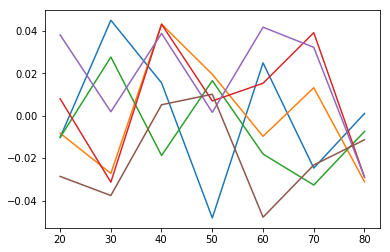

In [36]:
camHexPosMat = np.reshape(camHexPosMat,(-1,6))
print(camHexPosMat)
print(ElMat)
plt.plot(ElMat, camHexPosMat)
plt.show()

In [45]:
mode = await camHex.evt_compensationMode.aget(timeout=10)
print(mode)

MTHexapodID: 1, private_revCode: 68a842aa, private_sndStamp: 1612557402.1604373, private_rcvStamp: 1612563208.693136, private_seqNum: 2, private_identity: MTHexapod:1, private_origin: 35070, private_host: 0, enabled: True, priority: 0


In [44]:
offsetValue = await camHex.evt_compensatedPosition.aget(timeout=30)
print(offsetValue)

TimeoutError: 

In [40]:
LogMessages = await camHex.evt_logMessage.aget(timeout=10)
print(LogMessages)

MTHexapodID: 1, private_revCode: bf49d316, private_sndStamp: 1611954682.7134175, private_rcvStamp: 1612563209.0176404, private_seqNum: 6, private_identity: MTHexapod:1, private_origin: 35070, private_host: 0, name: MTHexapod, level: 20, message: Read historical data in 0.00 sec, traceback: , filePath: /opt/lsst/software/stack/miniconda/lib/python3.7/site-packages/lsst/ts/salobj/sal_info.py, functionName: start, lineNumber: 676, process: 35070, priority: 0


In [41]:
print(camHex.salinfo.event_names)

('actuatorInPosition', 'appliedSettingsMatchStart', 'authList', 'commandableByDDS', 'compensatedPosition', 'compensationMode', 'compensationOffset', 'configuration', 'connected', 'controllerState', 'errorCode', 'heartbeat', 'inPosition', 'interlock', 'logLevel', 'logMessage', 'settingVersions', 'settingsApplied', 'simulationMode', 'softwareVersions', 'summaryState', 'uncompensatedPosition')


### Questions 
Does the Hexapod tracks as soon as I send a pointing value?
How do you get the hexapod to apply the lookup table as a function of the elevation?

## Stop the system: stop the pointing kernel?

In [ ]:
await mtptg.cmd_stopTracking.start(timeout=10.)
#send the telescope to Park. Does not exist yet

In [ ]:
await rot.cmd_stop.start(timeout=10.)